In [1]:
import pandas as pd
from src.core.Processing import Processing
from src.core.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
file_path="/home/khaldi/Documents/data_app_machine/bank-additional-full.csv"
sep=";"
outcome="y"
positive_mod="yes"

In [3]:
df=pd.read_csv(file_path,sep=sep)

In [4]:
process=Processing() # object which do processing for df
analyzer=Analyser() #object which give graphics, statistics indicators for df

In [5]:
df.shape

(41188, 21)

In [6]:
process.summary(df)

{'Missing Values': age               0
 job               0
 marital           0
 education         0
 default           0
 housing           0
 loan              0
 contact           0
 month             0
 day_of_week       0
 duration          0
 campaign          0
 pdays             0
 previous          0
 poutcome          0
 emp.var.rate      0
 cons.price.idx    0
 cons.conf.idx     0
 euribor3m         0
 nr.employed       0
 y                 0
 dtype: int64,
 'Constant Features': []}

The dimension of the dataframe is (41188,21).
We can see that they don't have any missing values and constant features

no     0.887346
yes    0.112654
Name: y, dtype: float64

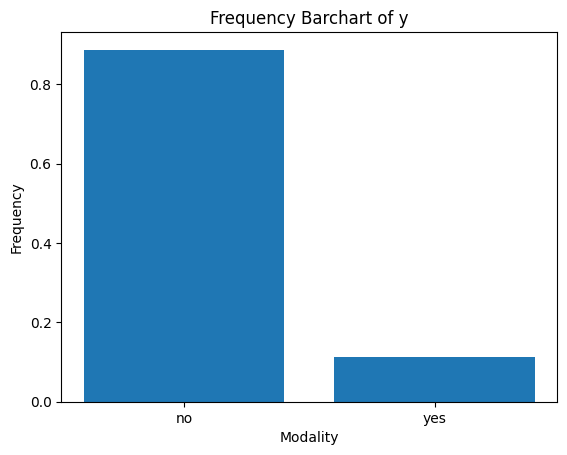

In [7]:
fig,ax=plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)

We can see above that, Attrition attribute is imbalanced ( 36548 (~94%) rows for "no" modality and 4640 (~5.4%) for "yes" modality)

In [8]:
analyzer_summary=analyzer.summary(df)
quantitatives,qualitatives=analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

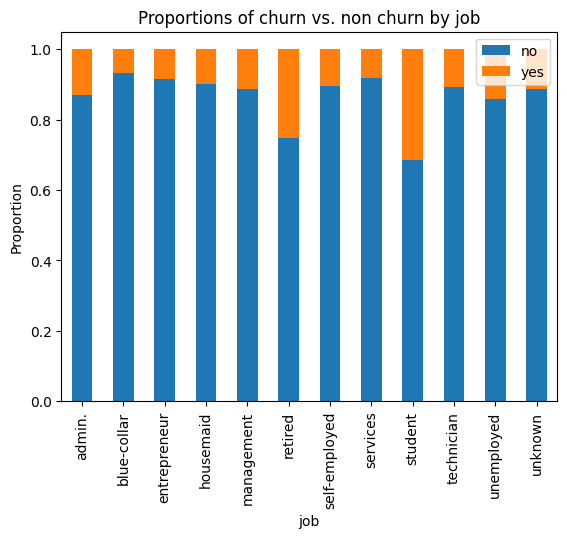

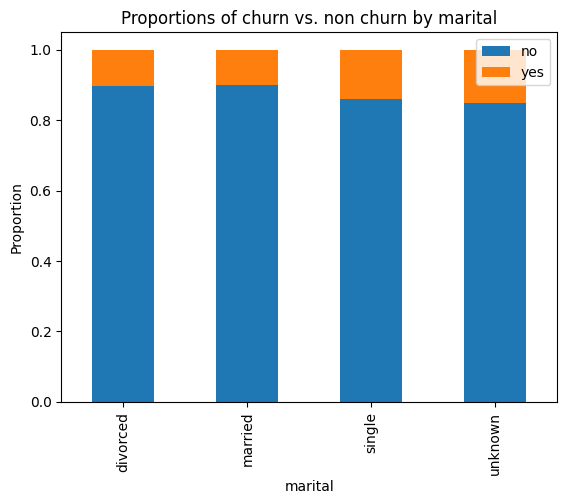

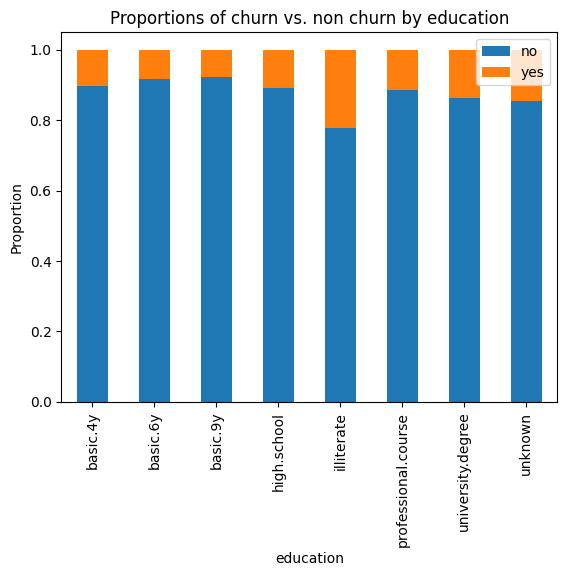

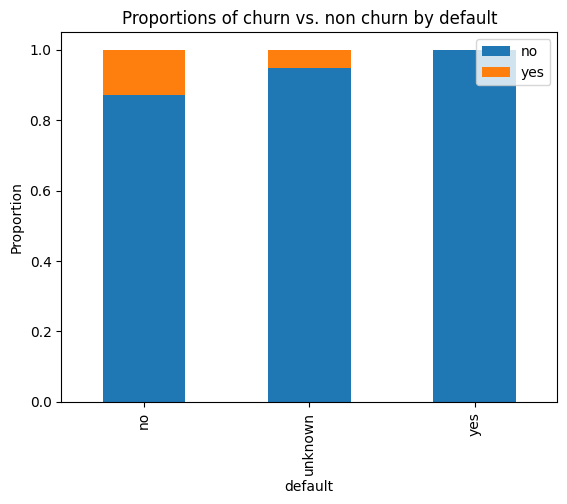

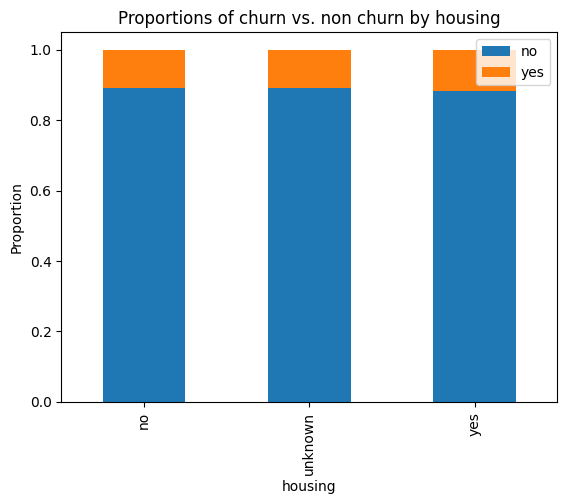

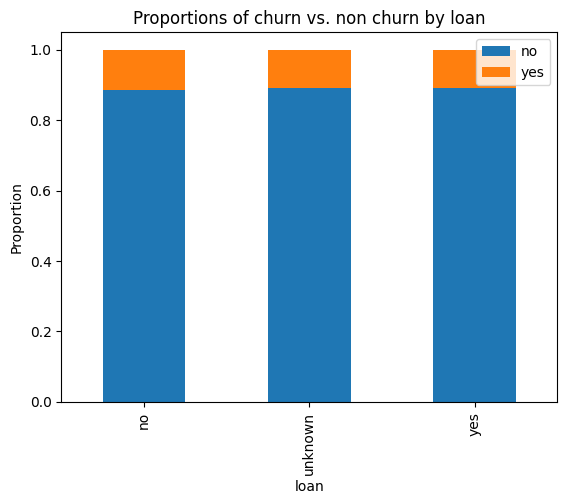

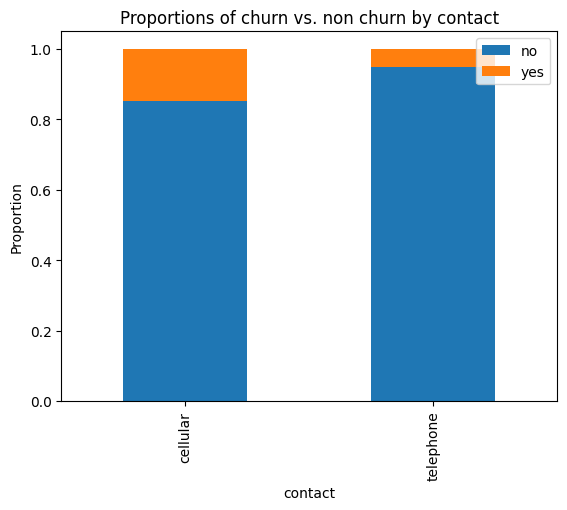

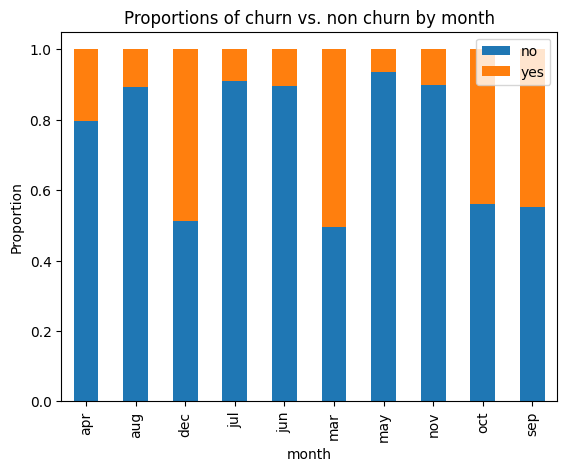

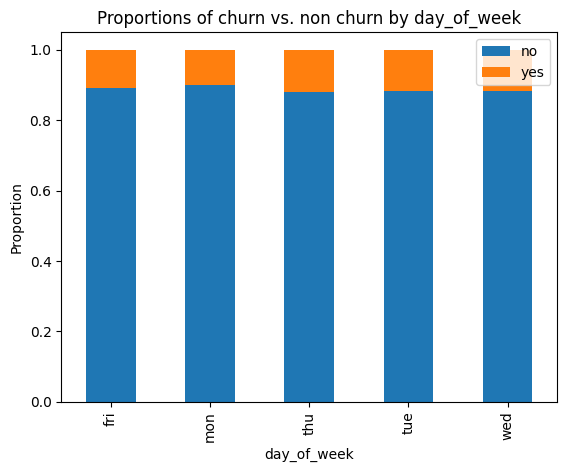

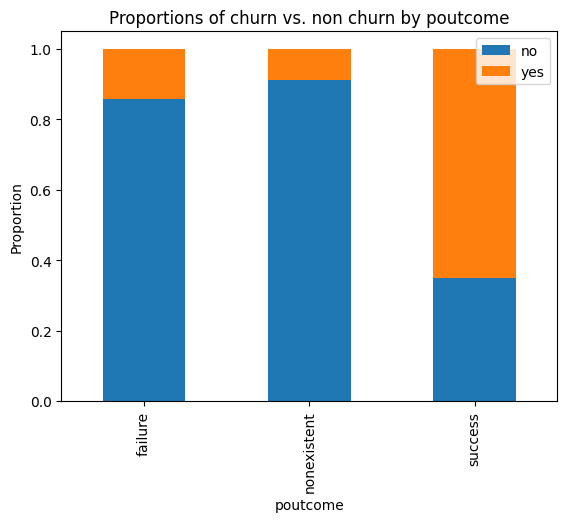

In [9]:
for c in analyzer.summary(df)["features"]["qualitative_columns"]:
    if c != outcome:
        analyzer.prop_churn_by_cats(df,outcome,c)

'job': influence, distributions are not identical
'marital': no influence, identical distributions (almost)
'education': a little influence, variance of proportion of positive people's (y==yes) conditioned by education is low (*)
'default': influence, identical distributions, people who has credit in default don't subscribe bank term deposit
'housing': no influence, identical distributions
'loan': no influence, identical distributions
'contact': influence, distributions are not identical
'month': influence, distributions are not identical
'day_of_week': no influence, identical distributions
'poutcome': influence, distributions are not identical
Conclusion:
'job', 'default', 'contact','month','poutcome' have influence
maybe also a little bit 'education'

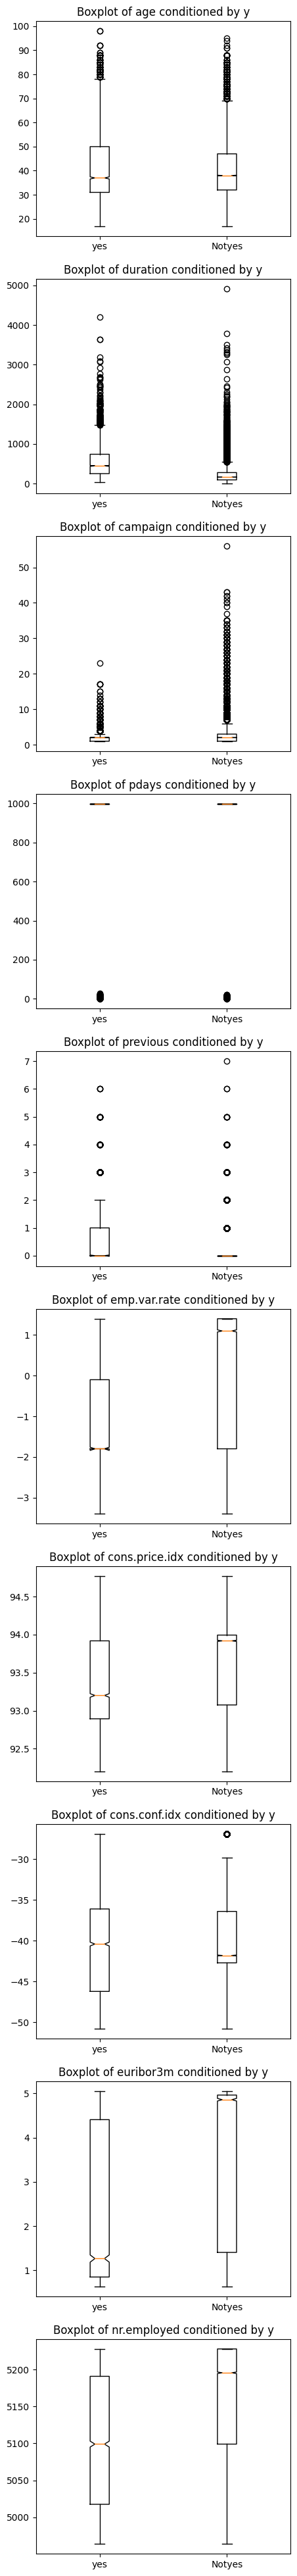

In [10]:
#df=process.remove_outliers(df)
fig,axs=plt.subplots(nrows=len(quantitatives),figsize=(5,len(quantitatives)*5))
for i in range(len(quantitatives)):
    analyzer.prop_churn_by_numerical_boxplot(df,outcome,positive_mod,quantitatives[i],axs[i])

'age': a little, little bit influence, distributions seems same (*)
'duration': influence, different median for distributions
'campaign': influence, different median for distributions
'pdays': influence:pdays is special, because when pdays=999, client didn't participate at previous campaign, but 999 is an outlier of pdays
'previous': influence: previous is special feature, a boxplot without outliers is not relevant because after removing features, "previous" become constant
'emp.var.rate': influence, different median for distributions
'cons.price.idx': a little bit influence, medians are equivalent (~93 to ~94 for this two medians)
'cons.conf.idx': a little bit influence, quantiles 75% seems be same, but quantile 25% are different (*)
'euribor3m': influence, different median for distributions
'nr.employed': influence, different median for distributions

Conclusion -relevant quantitative features:
duration, campaign, previous, pdays, emp.var.rate, euribor3m, nr.employed

In [11]:
relevant_features_quanti=[
    "duration",
    "campaign",
    "previous",
    "pdays",
    "emp.var.rate",
    "euribor3m",
    "nr.employed"
]
relevant_features_quali=[
    'job',
    'default',
    'contact',
    'month',
    'poutcome'
]
#we decided to remove 'poutcome' because when we removed outliers, this feature become constant
relevant_features=relevant_features_quanti+relevant_features_quali
df_new=df[[outcome]+relevant_features] #we decided to work with only relevant features for Attrition

<Axes: >

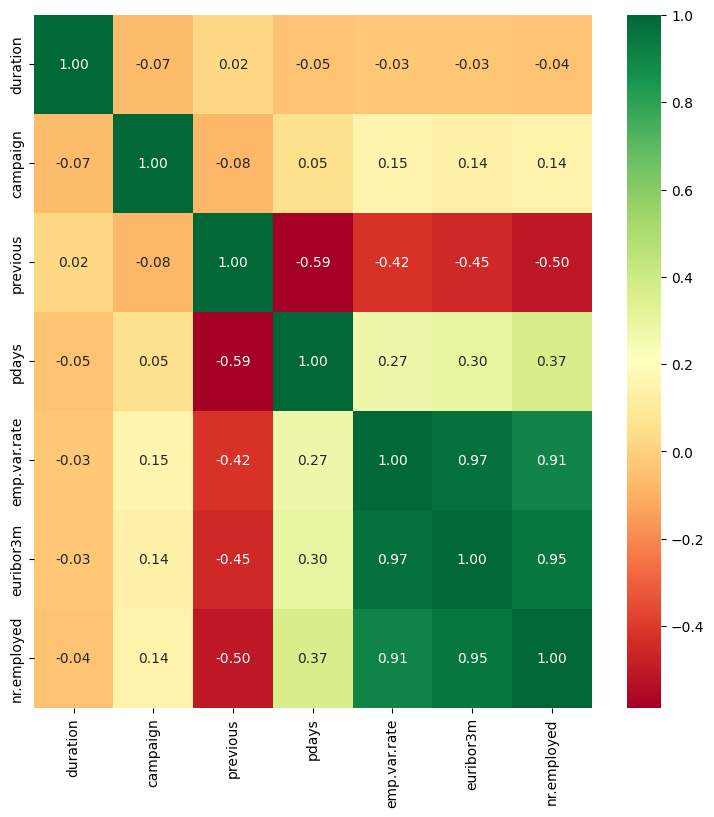

In [12]:
plt.figure(figsize=(9,9))
analyzer.correlation_heatmap(df_new,annot=True)

In [13]:
correlations=df_new.corr(numeric_only=True)
groups={1:.3,2:.6,3:.6}
"""
high correlation (>=.6): group3
medium correlation (>=.3 and <.6): group2
low correlation (<.3):group1
"""
print()

In [14]:
dict_correlations={key:[] for key in groups.keys()}
for group in groups.keys():
    if group==1:
        rows, cols =np.where(np.abs(correlations) < groups[group])
    elif group==2:
        rows, cols =np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group==3:
        rows, cols =np.where(np.abs(correlations) >= groups[group])
    dict_correlations[group]=[(correlations.index[row], correlations.columns[col], correlations.iloc[row, col]) \
                              for row, col in zip(rows, cols) if row != col]

In [15]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('duration', 'campaign', -0.07169922626415286),
  ('duration', 'previous', 0.020640350701749542),
  ('duration', 'pdays', -0.047577015445611645),
  ('duration', 'emp.var.rate', -0.027967884489332732),
  ('duration', 'euribor3m', -0.03289665570187456),
  ('duration', 'nr.employed', -0.04470322316242443),
  ('campaign', 'duration', -0.07169922626415286),
  ('campaign', 'previous', -0.07914147244884367),
  ('campaign', 'pdays', 0.052583573385024604),
  ('campaign', 'emp.var.rate', 0.15075380555787),
  ('campaign', 'euribor3m', 0.13513251080435595),
  ('campaign', 'nr.employed', 0.1440948948447463),
  ('previous', 'duration', 0.020640350701749542),
  ('previous', 'campaign', -0.07914147244884367),
  ('pdays', 'duration', -0.047577015445611645),
  ('pdays', 'campaign', 0.052583573385024604),
  ('pdays', 'emp.var.rate', 0.2710041742618581),
  ('pdays', 'euribor3m', 0.2968991123969819),
  ('emp.var.rate', 'duration', -0.027967884489332732),
  ('emp.var.rate', 'campaign', 0.15075380555787

We can see that 'emp.var.rate' and 'euribor3m' have very high correlations (~0.97)
'emp.var.rate' and 'nr.employed' have a correlation with .906 in absolute value.
We remove 'emp.var.rate', 'nr.employed' before training ML models

In [16]:
removed_features=["emp.var.rate","nr.employed"]
relevant_features=[f for f in relevant_features if f not in removed_features]
df_new_=df_new[[outcome]+relevant_features]

In [17]:
process.summary(df_new_)

{'Missing Values': y            0
 duration     0
 campaign     0
 previous     0
 pdays        0
 euribor3m    0
 job          0
 default      0
 contact      0
 month        0
 poutcome     0
 dtype: int64,
 'Constant Features': []}

In [18]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['y',
   'job',
   'default',
   'contact',
   'month',
   'poutcome'],
  'quantitative_columns': ['duration',
   'campaign',
   'previous',
   'pdays',
   'euribor3m']},
 'describe':            duration      campaign      previous         pdays     euribor3m
 count  41188.000000  41188.000000  41188.000000  41188.000000  41188.000000
 mean     258.285010      2.567593      0.172963    962.475454      3.621291
 std      259.279249      2.770014      0.494901    186.910907      1.734447
 min        0.000000      1.000000      0.000000      0.000000      0.634000
 25%      102.000000      1.000000      0.000000    999.000000      1.344000
 50%      180.000000      2.000000      0.000000    999.000000      4.857000
 75%      319.000000      3.000000      0.000000    999.000000      4.961000
 max     4918.000000     56.000000      7.000000    999.000000      5.045000}

In [19]:
###END OF SESSION 1

In [20]:
from src.core.ComputeModel import ComputeModel
from src.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="yes"
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
        }

In [21]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name,\
                                    hyperparameters=hyperparameters,positive_mod=positive_mod)
    models[model_name].fit()

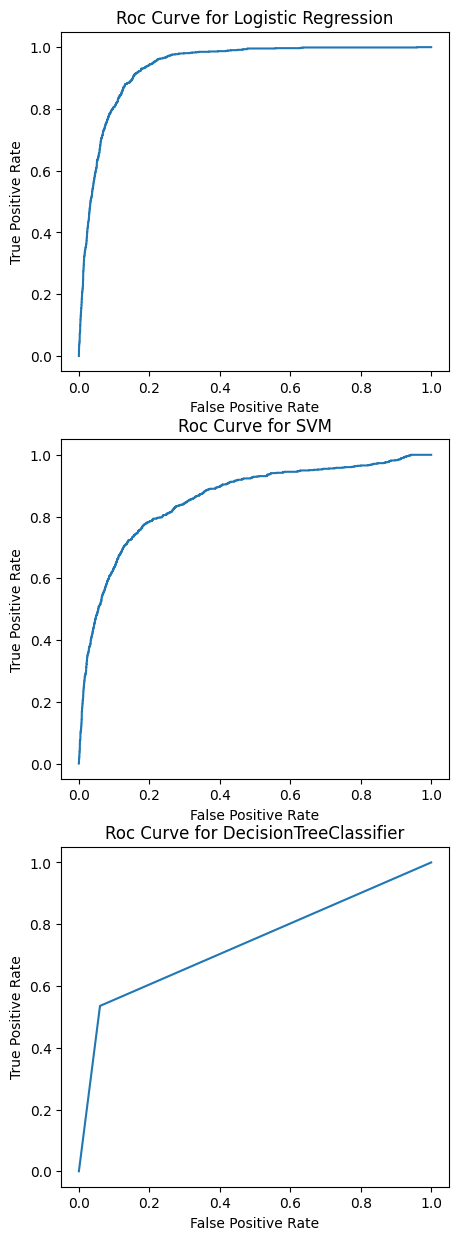

In [22]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}

In [23]:
metrics_default

{'Logistic Regression': {'auc': 0.9384230977876314,
  'accuracy': 0.9122359796067007,
  'precision': 0.6814159292035398,
  'recall': 0.41487068965517243,
  'f1_score': 0.5157401205626256},
 'SVM': {'auc': 0.8580512347280532,
  'accuracy': 0.8976693372177713,
  'precision': 0.5529265255292652,
  'recall': 0.47844827586206895,
  'f1_score': 0.512998266897747},
 'DecisionTreeClassifier': {'auc': 0.7377894446672014,
  'accuracy': 0.8945132313668366,
  'precision': 0.5315508021390374,
  'recall': 0.5355603448275862,
  'f1_score': 0.5335480407944176}}

In conclusion:
we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression and SVM  are the best model because auc ~ 0.920 and auc ~0.917 respectively for Logistic Regression and SVM:
  roc curve for 2 models are really good two concave curve with very high auc
- Decision Tree Classifier have 0.695 auc but f1-score are better than 2 others models.
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyperparameters)

In [24]:
distributions_test={model_name:None for model_name in models.keys()}
for model_name in models.keys():
    X_test=models[model_name].dict_split["arrays"]["X_test"]
    distributions_test[model_name]=models[model_name].model.predict_proba(X_test)
distributions_test

{'Logistic Regression': array([0.0190313 , 0.16489171, 0.23204396, ..., 0.41676087, 0.0412618 ,
        0.01898637]),
 'SVM': array([0.22839219, 0.28888484, 0.30195356, ..., 0.3157437 , 0.28405466,
        0.16583804]),
 'DecisionTreeClassifier': array([0., 0., 1., ..., 1., 0., 0.])}

In [25]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["liblinear"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [650,750]
            },
        "SVM":
            {
                "kernel": ["linear"],
                "C": [1,.1,.01],
                "degree": [3],
                "gamma": [1,.01,.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }
    }

In [26]:
def simulation(df_new_=df_new_,relevant_features=relevant_features,outcome=outcome,model_names=list(models.keys()),positive_mod=positive_mod,params_grid=params_grid,cv=3):
    models={model_name:{} for model_name in model_names}
    for model_name in model_names:
        for k in [0,5]:
            model=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                            process=process,model_name=model_name, \
                                            positive_mod=positive_mod,grid_search=True,cv=cv,params_grid=params_grid[model_name])
            model.fit(random_state=k)
            models[model_name][k]=model
    return models

In [27]:
def results(models_dict):
    return pd.DataFrame({k:model.metrics() for k,model in zip(models_dict.keys(),models_dict.values())})

In [ ]:
models_types=simulation()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
metrics_all_models={model_name:results(models_types[model_name]) for model_name in models_types.keys()}

In [ ]:
for model_name in models_types.keys():
    print(f"{model_name}:")
    print(metrics_all_models[model_name])
    print("\n")

we can observe that Logistic Regression have a good AUC (0.930) ,DecisionTreeClassifier (0.931) and SVM (0.889) also with cross validation.
f1 score is low in 3 model (0.5 to 0.6) because the dataset is imbalanced and during sequence 4, we wiil do oversampling/under sampling to equilibrate the dataset.
Conclusion: with tuning and cross validation, metrics (auc) increase globally in 3 models. furthermore results has been reliable with cross validation.
But a problem of imbalanced dataset is not resolved and during sequence 4, we are going do a over/under sampling to equilibrate dataset.
the best model of 3 is DecisionTreeClassifier because he have a best AUC (with Logistic Regression) with cross validation and other metrics are best also, precisely precision and recall, f1 score are high (~0.61) for an imbalanced dataset

In [ ]:
best_model=models_types["DecisionTreeClassifier"][0]
hyperparameters=best_model.model.hyperparameters

In [26]:
###END OF SESSION 2

In [27]:
model_random=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                          process=process,model_name="RandomForestClassifier", \
                          positive_mod=positive_mod,grid_search=True)
model_random.fit()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [28]:
model_random.metrics()

{'auc': 0.9490197798245201,
 'accuracy': 0.9169701383831027,
 'precision': 0.7520661157024794,
 'recall': 0.3922413793103448,
 'f1_score': 0.5155807365439093}

We can see that auc is very good and accuracy as well, we need to balanced the dataset to imporove f1-score (precision,recall also because
the model have bias for majority class for outcome ("y" variable). I think the dataset is too imbalanced.

In [29]:
best_model=model_random.model.model
hyperparameters_best=model_random.model.hyperparameters

In [30]:
hyperparameters_best

{'max_depth': 12, 'n_estimators': 131}

In [31]:
best_model

RandomForestClassifier(max_depth=12, n_estimators=131)

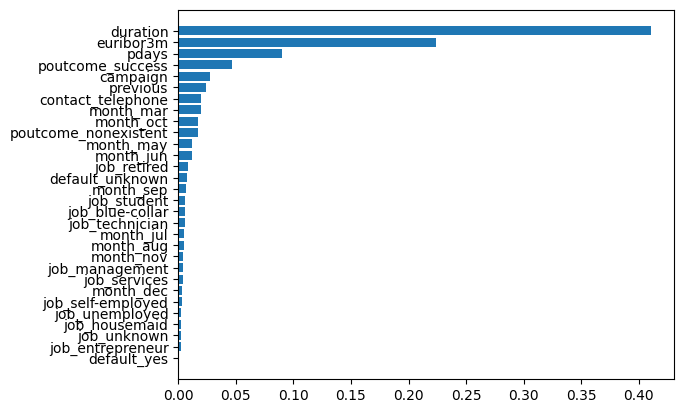

In [32]:
importances=best_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(model_random.dict_split["columns_features"])[indices])

In [33]:
model_random.dict_split["columns_features"]

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_unknown', 'default_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_nonexistent',
       'poutcome_success', 'duration', 'campaign', 'previous', 'pdays',
       'euribor3m'],
      dtype='object')

We can see that "duration", "euribor3m", "pdays", "poutcome", "campaign" are top 5 of most influent features for RandomForestClassifier

In [34]:
relevant_features_top5=["duration","euribor3m","pdays","poutcome","campaign"]
model_top5=ComputeModel(df_new_[relevant_features_top5],df_new_[outcome], \
                        process=process,model_name="RandomForestClassifier", \
                        positive_mod=positive_mod,hyperparameters=hyperparameters_best)

In [35]:
model_top5.fit()

In [36]:
model_top5.metrics()

{'auc': 0.9461475187508844,
 'accuracy': 0.9203690216071863,
 'precision': 0.6873278236914601,
 'recall': 0.5377155172413793,
 'f1_score': 0.603385731559855}

In [37]:
relevant_features_bad3=["job","default","month"]
model_bad3=ComputeModel(df_new_[relevant_features_bad3],df_new_[outcome], \
                        process=process,model_name="RandomForestClassifier", \
                        positive_mod=positive_mod,hyperparameters=hyperparameters_best)

In [38]:
model_bad3.fit()

In [39]:
model_bad3.metrics()

{'auc': 0.7053555002594462,
 'accuracy': 0.887836853605244,
 'precision': 0.5416666666666666,
 'recall': 0.028017241379310345,
 'f1_score': 0.05327868852459016}

We can see a coherence, the 5 most influent features for RandomForestClassifier give a good model with high score (auc~ 0.945, accuracy~0.92)
and with the 3 less influent features, model give a metrics that it is smaller than model with 5 most influent features.
Furthermore, with model_top5, we simplify the model (decrease number of features). And metrics with 5 most influent features and model with
full relevant features are almost same (even an increase of f1-score!)

In [40]:
relevant_features_top5=relevant_features_top5
model_seq3=model_top5

In [41]:
hyperparameters_best

{'max_depth': 12, 'n_estimators': 131}

In [42]:
model_seq3

In [43]:
###END OF SESSION 3